### Plotting of Immune biomarkers Figure 3 - new version

In [2]:
wd = "/workspace/projects//immune_biomarkers/repo/immune_biomarkers/"
setwd(wd)

#source("/home/arosendahl/immune_biomarkers/mission_control/treasure_map.R")
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/exhaustive_plots.R"))
source(paste0(wd,"/mission_control/helpers/figures/exhaustive_settings.R"))
source(paste0(wd,"/mission_control/helpers/figures/themes.R"))

library(tidyverse)
library(data.table)
library(ggrepel)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)
library(ggh4x)
library(cowplot)
# library(grImport2)
# library(rsvg)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The foll

### Figure 3A

In [3]:
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))
labels <- readRDS(paste0(TMP_DIR,"exhaustive-plots-labels.Rds"))
threshold <- -log10(ingredients$by_05_fdr)[1]

In [4]:
drop_features <- c("tcell", "tmb", "prolif","tgfb","pretreat","pretreat_comp","tissue",
                   "tissue_full","age","biopsy","purity","pdl1")

In [5]:
# pool CNVs and SV's in the same category (they are not very important in this context)
ingredients = ingredients %>% 
    filter(!feature %in% drop_features)  %>% 
    filter(!grepl("cibersort", feature)) %>% 
    mutate(big_group = case_when(big_group == "CNV" ~ "CNV/SVs", 
                                 big_group =="SVs" ~ "CNV/SVs", 
                                 .default = big_group))

ingredients3 = ingredients %>%
    filter(model == "os" & dataset == "all" & covariates == "residuals") %>% 
    filter(!feature %in% c("isofox_gene_set_t_cell_effector", "tcell", "isofox_gene_set_tcell_cluster"))  %>% 
    filter(!grepl("tgfb_cluster|prolif_cluster|tcell_cluster", feature))  %>% 
    filter(!feature %in% c("prolif", "tgfb"))

In [6]:
ingredients3$pval_significance = ifelse(ingredients3$p_val <= ingredients3$by_05_fdr, "sign", "non-sign")

In [7]:
color_map$RNA = "#e0ba92" # change the RNA feature value to a more direct value. Original color: "#FC913A"
color_map$`CNV/SVs` = "#B3DE69"
color_map$Somatic = "#80B1D3"
color_map$CNV = color_map$SVs = NULL
set.seed(12345) # set seed to keep random order
ingredients3$pval_significance = ifelse(ingredients3$p_val <= ingredients3$by_05_fdr, "sign", "non-sign")

In [8]:
exhaustive_theme_left_legend = exhaustive_theme_left + theme(legend.position = "right")

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


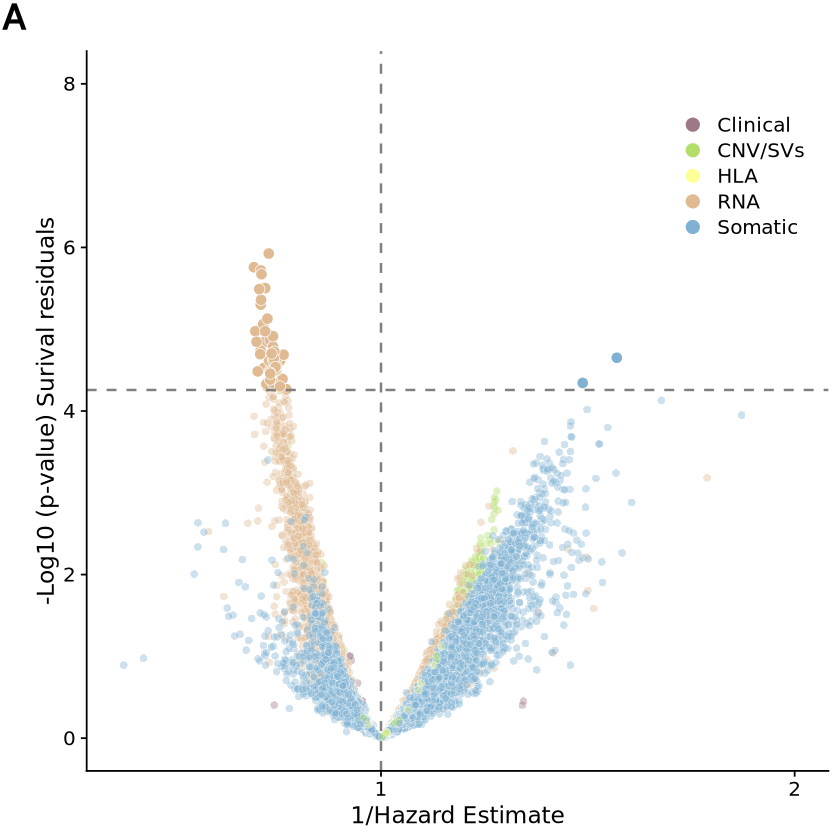

In [9]:
ingredients_plot = ingredients3 %>%
    filter(dataset == "all",
           model == "os" ,
           covariates == "residuals",
          Group != "Gene Set") # check with Joe if we want to keep this last part in

fig3a = ggplot(ingredients_plot, aes(x = plot_est, y = log10_p,
                           size = log10_p > threshold, 
                           alpha = log10_p > threshold)) + 
    geom_point(aes(fill = big_group), shape = 21, stroke = 0.3, color = "white") + 
    scale_fill_manual(values = c("#9E7788", "#B3DE69","#FFFF99", "#e0ba92" ,"#80B1D3") ) +  # original color "#FC913A"
    geom_vline(xintercept = 1, linetype="dashed", color = "grey50", linewidth=0.7) + 
    geom_hline(yintercept = threshold, linetype="dashed", color = "grey50", linewidth=0.7) + 
    scale_y_continuous(breaks = c(seq(0,8,2)), limits = c(0,8)) + 
    scale_x_continuous(breaks = c(1,2), limits = c(.37,2))  +
    scale_size_manual(values = c(2, 3))  +
    scale_alpha_manual(values = c(0.4, 1)) + 
    cowplot::theme_cowplot() + 
    theme(legend.position = c(0.8, 0.85),
          legend.background = element_blank()) + 
    guides(alpha = "none", size = "none", # remove the 'pval size'
           fill = guide_legend(title = "", override.aes = list(size=4)),
           color = guide_legend(title = "")) +
    labs(title = "", x = "1/Hazard Estimate", y = "\n-Log10 (p-value) Surival residuals")    

fig3a <- annotate_figure(fig3a, fig.lab = "A", fig.lab.size = 20, fig.lab.face = "bold")
fig3a

### Figure 3B

In [10]:
ready <- readRDS(paste0(I_DIR, "cpi_go.Rds"))
results <-readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))  %>% 
    filter(!grepl("tgfb_cluster|prolif_cluster|tcell_cluster", feature))  %>% 
    filter(!feature %in% drop_features)
cutoff <- results$by_05_fdr[1]

In [11]:
one_set_result <- results %>% filter(model == "os" & dataset == "all" & covariates == "age_biopsy_purity_tissue") 
os_resid_set_result<- results %>% filter(model == "os" & dataset == "all" & covariates == "residuals") 

In [12]:
# drop features are duplicated features
drop_features <- c("tcell", "tmb", "prolif","tgfb","pretreat","pretreat_comp","tissue","tissue_full","age","biopsy","purity","pdl1")
#There 2 significant features not expression - check!!! For now they are excluded
weird_features <- c("cnv.region_loh_chr11.q23.3","somatic.gene_MATN2.mb")
top_os_resid <- results %>%
    filter(model == "os", dataset == "all", covariates == "residuals") %>%
    filter(!feature %in% drop_features) %>%
    filter(!feature %in% weird_features) %>%
    filter(!grepl("gene_set_", feature)) %>%
    filter(!grepl("cibersort", feature)) %>%
    filter(!grepl("somatic", feature))  %>% 
    filter(p_val < cutoff) %>%
    pull(feature)

In [13]:
os_resid_cor_go <- ready %>% select(all_of(top_os_resid))  %>% drop_na() 
cor_matrix_os_resid = cor(as.matrix(os_resid_cor_go))

In [14]:
# Generate clusters
tree <- hclust(as.dist(1-abs(cor_matrix_os_resid)),method = "ward.D2")
tree_clust = cutree(as.hclust(tree), k = 3)
cluster1 = tree_clust[tree_clust == 1]
cluster2.1 = tree_clust[tree_clust == 3]
cluster2.2 = tree_clust[tree_clust == 2]
clusters = c(cluster1, cluster2.1, cluster2.2)

In [15]:
# save the names of the genes in the cluster
df1 = data.frame(T_cell = names(cluster1))
#write.table(df1, "1_figures/figure3/Prolif_cluster_genes.txt", col.names = FALSE, row.names = FALSE, quote = FALSE)

df2 = data.frame(T_cell = names(cluster2.1))
#write.table(df2, "1_figures/figure3/TGBF_cluster_genes.txt", col.names = FALSE, row.names = FALSE, quote = FALSE)       

In [16]:
wdf <- one_set_result[,c("feature", "big_group")] %>% filter(feature %in% top_os_resid)
wdf$w = 3
# TODO match order of the figures with the order of the clusters!!!!!
ord = match(names(clusters), wdf$feature)
wdf = wdf[tree$order,]
wdf$clustord = 1:nrow(wdf)
wdf = wdf %>% arrange(clustord)
breaks <- wdf %>% 
  mutate(cumw = cumsum(w),
         pos = .5 * (cumw + lag(cumw, default = 0))) %>% 
  select(feature, pos)

In [17]:
os_resid_cor_go = os_resid_cor_go[match(wdf$feature, names(clusters)),]
pd <- as.data.frame(cor_matrix_os_resid)
pd$feature <- rownames(pd)
pd.m <- pivot_longer(pd, -feature, names_to = "variable")

In [18]:
pd.m <- pd.m %>% 
  left_join(breaks, by = c("variable" = "feature")) %>% 
  rename(y = pos) %>% 
  left_join(breaks, by = c("feature" = "feature")) %>% 
  rename(x = pos)

In [19]:
pd.m <- pd.m %>% 
  left_join(wdf, by = c("feature" = "feature")) 

In [20]:
pd.m <- pd.m %>% 
  left_join(wdf[,c(1,2)], by = c("variable" = "feature")) 

In [21]:
RNA_features = wdf[wdf$big_group == "RNA",]$feature

In [22]:
pd.m$feature <- factor( pd.m$feature, levels = colnames(os_resid_cor_go)[ord] )
pd.m$variable <- factor(pd.m$variable, levels = colnames(os_resid_cor_go)[ord] )
pd.m$height = 3
pd.m$width =  3

In [23]:
pd.m$Type = ifelse(pd.m$big_group.x == "RNA", "Expression", ifelse(pd.m$big_group.x == "Somatic", "SNVs/Indels", "Clinical"))
pd.m$Type2 = ifelse(pd.m$big_group.y == "RNA", "Expression", ifelse(pd.m$big_group.y == "Somatic", "SNVs/Indels", "Clinical"))

In [24]:
# Add the 'n value' to each column name in the plot
cl1 = paste0("Cluster S1\n(n = ", length(cluster1), ")")
cl2.1 = paste0("Cluster S2.1\n(n = ", length(cluster2.1), ")")
cl2.2 = paste0("Cluster S2.2\n(n = ", length(cluster2.2), ")")

In [25]:
pd.m = pd.m %>% 
    mutate(Type = case_when(variable %in% names(cluster1) ~ cl1,
                          variable %in% names(cluster2.1) ~ cl2.1,
                            variable %in% names(cluster2.2) ~ cl2.2,
                            .default = Type)) 

pd.m = pd.m %>% 
    mutate(Type2 = case_when(feature %in% names(cluster1) ~ cl1,
                          feature %in% names(cluster2.1) ~ cl2.1,
                          feature %in% names(cluster2.2) ~ cl2.2,
                             .default = Type2))

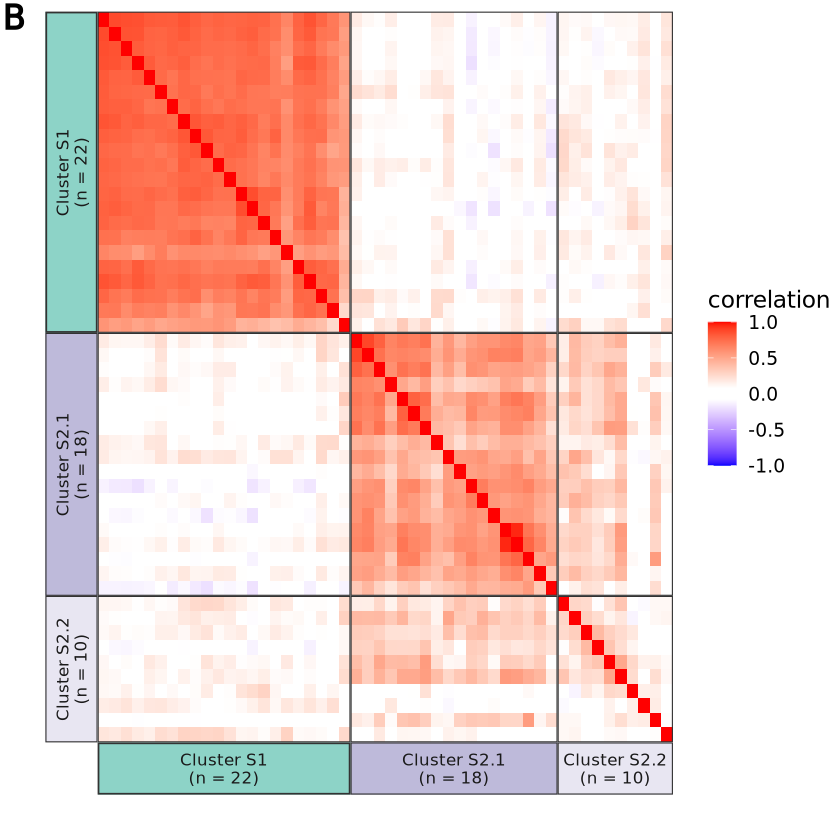

In [26]:
fig3b <- ggplot(pd.m, aes(x = x, y = y)) +
  geom_tile(aes(width = width,  height = height, fill = value)) +
  scale_x_reverse(breaks = breaks$pos, labels = breaks$feature, expand = c(0, 0.1)) +
  scale_y_continuous(breaks = breaks$pos, labels = breaks$feature, expand = c(0, 0.1))+
  scale_fill_gradientn(limits = c(-1, 1), colours = c("blue", "white", "white",  "red"), values = c(0, 0.46, 0.54, 1)) +
  theme(panel.border=element_rect(fill = NA, colour="black",linewidth=1))+
  theme_bw(base_size = 14) +
  facet_grid2(Type ~ Type2, scales = "free", space = "free", switch = "both",
              strip = strip_themed(background_x = elem_list_rect(fill = c("#8DD3C7","#BEBADA","#e8e6f2"), size= 1),
                                    background_y = elem_list_rect(fill = c("#8DD3C7","#BEBADA", "#e8e6f2"), size= 1)))+
  theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        axis.title.y = element_text(size=14),
        axis.title.x = element_text(size=14),
        strip.text.x = element_text(size = 10),
        strip.text.y = element_text(size = 10),
        panel.spacing.x = unit(0, "mm"),
        panel.spacing.y = unit(0, "mm"),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
       # panel.background = element_rect(fill = NA, color = "black", linewidth = 10),
        panel.grid = element_blank(),
        legend.position="right") + 
    xlab("") + ylab("") + 
    labs(fill = "correlation")

fig3b <- annotate_figure(fig3b, fig.lab = "B", fig.lab.size = 20, fig.lab.face = "bold")
fig3b

### Figure 2C
Intermediate correlation plots
- Datapoints: HMF patients
- y = expression 'heatmap cluster' mean 
- x = expression geneset mean
- Take two genesets and display the correlation, to show how we get to point 2C 

In [27]:
ready <- readRDS(paste0(I_DIR, "cpi_go.Rds"))

In [28]:
# load gene sets
gsea_sets <- readRDS(paste0(REF_DIR,"GSEA_gene_sets.Rds"))
cpi_gene_sets <- readRDS(paste0(REF_DIR,"cpi1000_gene_sets.Rds"))
gsea_sets = gsea_sets[setdiff(names(gsea_sets), names(cpi_gene_sets))]
gene_sets = c(gsea_sets, cpi_gene_sets) # combine the two geneset lists
names(gene_sets) = gsub("gene_set_", "", names(gene_sets))
names(gene_sets) = gsub("gene_set_", "", names(gene_sets))

gene_sets = gene_sets[!grepl("battle_|tgfb_|vhio|08283|rand", names(gene_sets))]

# load the filtered gene set list 
geneset_filtered = data.table::fread("ref/Table_S2_255_genesets.csv")  %>% 
    mutate(simplename = case_when(Source =="Used in Mariathasan TGFB Paper" ~ paste0("m_", simplename), 
                                  .default = simplename))  %>% 
    mutate(simplename = gsub("cd_8", "cd8", simplename))

# rename the geneset names
names(gene_sets) = tolower(names(gene_sets))
idx_mariathan = !names(gene_sets) %in% geneset_filtered$simplename
names(gene_sets)[idx_mariathan] = paste0("m_", names(gene_sets)[idx_mariathan])

In [29]:
# Select T-cell effector geneset as an example to show the correlation
select_sets = gene_sets[c("t_cell_effector", "pan_tbrs", "prolif")]
select_sets = lapply(select_sets, \(x) paste0("isofox_", x)) # add isofox to identify genes
cluster_list = list(`cluster 1` =  names(cluster1), 
                    `cluster 2.1` = names(cluster2.1), 
                    `cluster 2.2` = names(cluster2.2))
total_sets = c(select_sets, cluster_list)
total_sets = sapply(total_sets, \(x) x[(x %in% colnames(ready))]) # select the number of genes not in the data

In [30]:
# generate cluster means: 
ready_m = ready |> select(starts_with("isofox")) |> as.matrix()# make matrix to allow for looping
patient_means = sapply(total_sets, \(x) rowMeans(ready_m[,x]))

In [31]:
colnames(patient_means)[1:3] = c("T-Cell effector", "TGF-beta fibroblasts", "Proliferation potential")

In [32]:
# generate the plotting dataframe - make it possible that the individual patient expression of the T-cell cluster, and cluster 3 are clearly visible.
pm = patient_means  %>% 
    as.data.frame() %>% 
    mutate(patient = 1:nrow(patient_means))  %>% 
    drop_na()

Warning message:
“The dot-dot notation (`..r.label..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(r.label)` instead.”


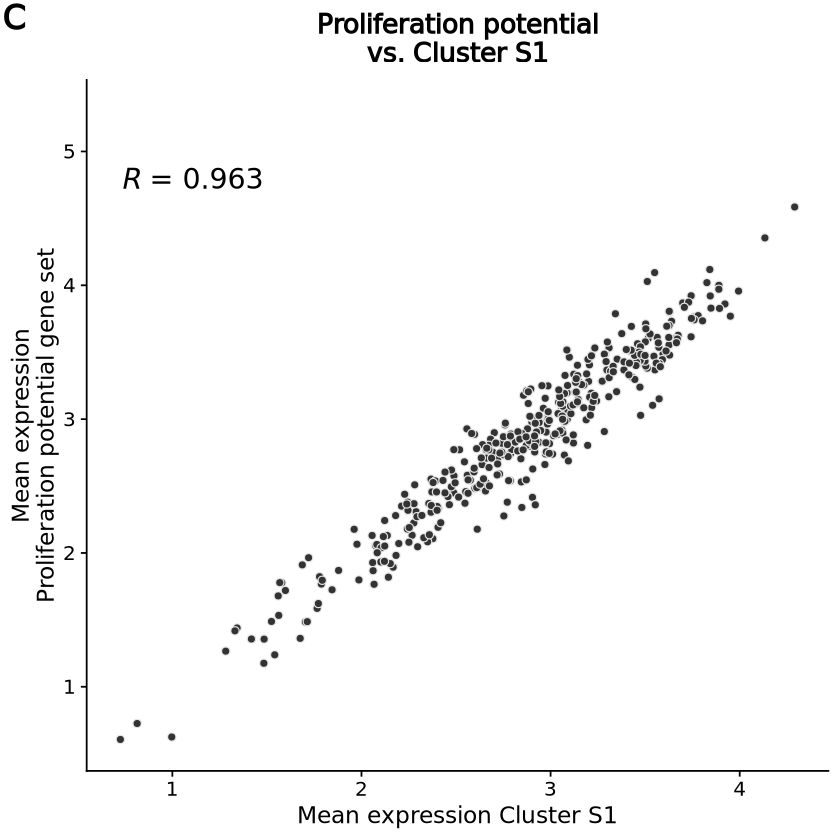

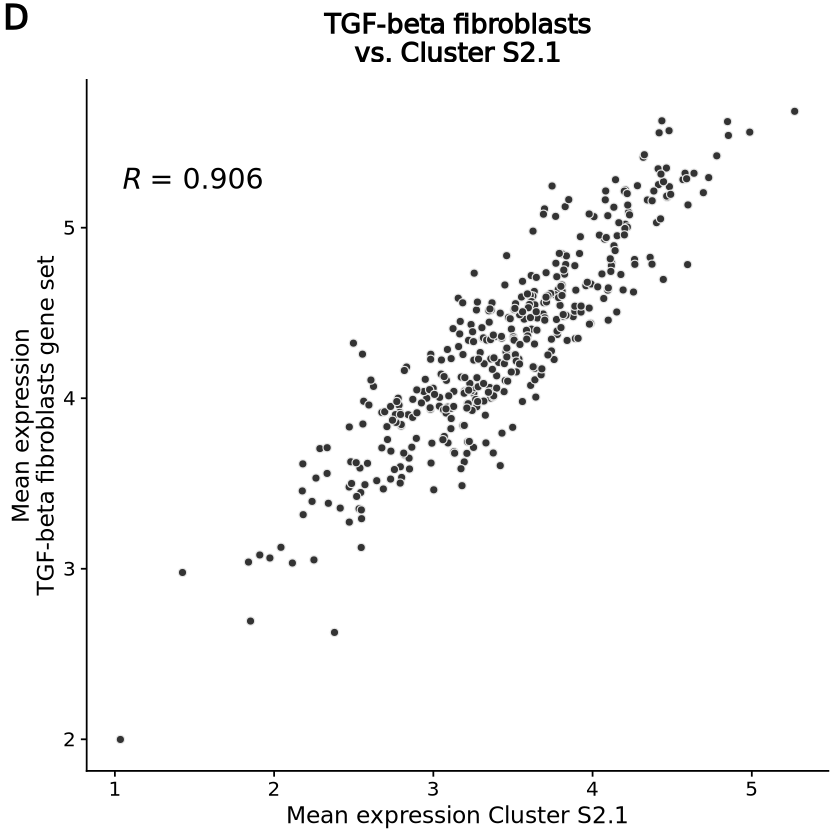

In [33]:
# plot for the figure: 
fig3c = ggplot(pm, aes(x = `cluster 1`, y = `Proliferation potential`, fill = "Individual\nPatient")) + 
    geom_point(shape = 21, color = "grey90", size = 2) + 
  scale_fill_manual(values = "grey20") +
  cowplot::theme_half_open() +
  ggpubr::stat_cor(aes(label = ..r.label..), method = "pearson", size = 6, label.y.npc = 0.9,  digits = 3) + 
  scale_y_continuous(limits = c(NA, 5.3)) + 
  theme(strip.background = element_blank(), strip.text = element_text(face="bold"), 
        plot.title = element_text(hjust = 0.5), 
        legend.position = "none")  + 
  labs(title = "Proliferation potential\nvs. Cluster S1", 
       x = "Mean expression Cluster S1", 
       y = "Mean expression\nProliferation potential gene set", 
       fill = NULL)
fig3c <- annotate_figure(fig3c, fig.lab = "C", fig.lab.size = 20, fig.lab.face = "bold")
fig3c


# plot for the figure: 
fig3d = ggplot(pm, aes(x = `cluster 2.1`, y = `TGF-beta fibroblasts`, fill = "Individual\nPatient")) + 
    geom_point(shape = 21, color = "grey90", size = 2) + 
  scale_fill_manual(values = "grey20") +
  cowplot::theme_cowplot() +
  ggpubr::stat_cor(aes(label = after_stat(r.label)),method = "pearson", size = 6, label.y.npc = 0.9,  digits = 3) + 
  theme(strip.background = element_blank(), strip.text = element_text(face="bold"),
        plot.title = element_text(hjust = 0.5), 
        legend.position = "none")  + 
  labs(title = "TGF-beta fibroblasts\nvs. Cluster S2.1", 
       x = "Mean expression Cluster S2.1",
       y = "Mean expression\nTGF-beta fibroblasts gene set",
       fill = NULL)


fig3d <- annotate_figure(fig3d, fig.lab = "D", fig.lab.size = 20, fig.lab.face = "bold")
fig3d

# supplementary figure XX 
Plot the correlation of all the somatic mutation features against the mean of cluster 1: Somatic features
When finalizing the scripts, this code could be part of the supplementary figure function for the genesets

In [34]:
read_features = ready %>% select(any_of(unique(ingredients3$feature)))

In [35]:
mean_cl1 = rowMeans(read_features %>% select(all_of(names(cluster1))))
mean_cl2.1 = rowMeans(read_features %>% select(all_of(names(cluster2.1))))
mean_cl2.2 = rowMeans(read_features %>% select(all_of(names(cluster2.2))))

In [36]:
# filter the features for the values for which we have observations 
na_values = which(is.na(mean_cl2.1))
read_features_filtered = read_features  %>% slice(-na_values)
mean_cl1_filtered = mean_cl1[-na_values]
mean_cl2.1_filtered = mean_cl2.1[-na_values]
mean_cl2.2_filtered = mean_cl2.2[-na_values]

cluster_cors = tibble(feature = colnames(read_features_filtered),
                   `Expression cluster S1 = Proliferation potential` = cor(mean_cl1_filtered, read_features_filtered, use = "complete.obs") %>% as.numeric(),
                   `Expression cluster S2.1 = TGF-beta fibroblasts` = cor(mean_cl2.1_filtered, read_features_filtered, use = "complete.obs") %>% as.numeric(),
                   `Expression cluster S2.2` = cor(mean_cl2.2_filtered, read_features_filtered,  use = "complete.obs") %>% as.numeric())

Warning message in cor(mean_cl1_filtered, read_features_filtered, use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(mean_cl2.1_filtered, read_features_filtered, use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(mean_cl2.2_filtered, read_features_filtered, use = "complete.obs"):
“the standard deviation is zero”


In [37]:
cluster_cors = cluster_cors %>% filter(feature %in% unique(ingredients3$feature))
i_cors = left_join(ingredients3, cluster_cors,by = "feature" )

In [38]:
colnames(read_features_filtered)[grepl("effe", colnames(read_features_filtered))]

[1] "isofox_gene_set_cd8_t_effector"           
[2] "isofox_gene_set_mariathan_CD_8_T_effector"
[3] "isofox_gene_set_battle_tcell_effector_cd8"

In [39]:
# merge and filter the labels to match value: 
label_cors = left_join(ingredients3, cluster_cors,by = "feature" ) %>% 
    filter(log10_p > threshold)

label_cors = label_cors %>% 
    mutate(big_group = case_when(
        grepl("gene_set", feature) & `Expression cluster S1 = Proliferation potential` > 0.8 & log10_p > threshold ~ "high corr. Cluster S1",
        grepl("gene_set", feature) & `Expression cluster S2.1 = TGF-beta fibroblasts` > 0.8 & log10_p > threshold ~ "high corr. Cluster S2",
        .default = big_group))

In [40]:
label_cors = label_cors %>% 
    select(starts_with("Expr"), big_group, log10_p, feature) %>% 
    pivot_longer(cols = starts_with("Expr"), names_to = "cluster", values_to = "correlation") %>% 
    filter(correlation > 0.8) %>% 
    filter(grepl("gene_set", feature)) %>% 
    filter(!grepl("rand|vhio", feature))  %>% 
    mutate(feature2 = gsub("isofox_|gene_set_|mariathan_", "", feature)  %>% tolower())

In [41]:
label_cors = label_cors  %>% 
    mutate(label = geneset_filtered$Alias[match(feature2, geneset_filtered$simplename)])

In [42]:
i_cors = i_cors %>% 
    mutate(big_group = case_when(
        grepl("gene_set", feature) & `Expression cluster S1 = Proliferation potential` > 0.8 & log10_p > threshold ~ "high corr. Cluster S1",
        grepl("gene_set", feature) & `Expression cluster S2.1 = TGF-beta fibroblasts` > 0.8 & log10_p > threshold ~ "high corr. Cluster S2",
        .default = "other"))  %>% 
     mutate(big_group = factor(big_group, 
                              levels = c("RNA", "high corr. Cluster S1",
                                         "high corr. Cluster S2", "other"))) # set the levels for plotting
    

In [43]:
input_cors = i_cors %>%  
    filter(model == "os" & dataset == "all" & covariates == "residuals") %>% 
    select(starts_with("Expression"), big_group, log10_p, feature) %>% 
    pivot_longer(cols = starts_with("Expression"), names_to = "cluster", values_to = "correlation")

In [44]:
input_cors = input_cors  %>% filter(!grepl("rand1", feature))  %>% 
    mutate(big_group = factor(big_group, levels = unique(big_group)))

In [45]:
for (clust in unique(input_cors$cluster)) {
    features = input_cors  %>% 
        filter(cluster %in% clust & log10_p > threshold)  %>% 
        arrange(desc(correlation))  %>% 
        mutate(feature = gsub("isofox_", "", feature))      
 #   readr::write_excel_csv(features, paste0("1_figures/figure3//", clust, "features.csv"))
}

In [46]:
cluster_1 = input_cors  %>% filter(cluster == "Expression cluster S1 = Proliferation potential", grepl("gene_set", feature))
#readr::write_excel_csv(cluster_1, "1_figures/figure3/Figure3_geneset_correlation_ClusterS1.csv")
cluster_2.1 = input_cors  %>% filter(cluster == "Expression cluster S2.1 = TGF-beta fibroblasts", grepl("gene_set", feature))
#readr::write_excel_csv(cluster_2.1, "1_figures/figure3/Figure3_geneset_correlation_ClusterS2.1.csv")

In [47]:
# Better to rewrite the entire function again instead of working with ggplot facet grid options too much: 
input_cors2 =  input_cors  %>% 
    filter(grepl("gene_set", feature))  %>% 
    filter(!grepl("S2.2", cluster))  %>% 
    pivot_wider(names_from = "cluster", values_from = "correlation")  %>% 
    rename(cluster1 = 4, cluster2 = 5)  %>% 
    mutate(color1 = case_when(
        cluster1 >= 0.5 & log10_p > threshold~ "#BEBADA", 
        cluster2 >= 0.5 & log10_p > threshold ~ "#8DD3C7", 
        log10_p < threshold ~ "grey70", .default = "grey"))    %>% 
    mutate(color2 = case_when(
        cluster2 >= 0.5 & log10_p > threshold~ "#8DD3C7", 
        cluster1 >= 0.5 & log10_p > threshold~ "#BEBADA", 
        log10_p < threshold ~ "grey70", .default = "grey"))  

In [48]:
label_cors2 = label_cors  %>%  pivot_wider(names_from = "cluster", values_from = "correlation")  %>% 
    rename(cluster1 = 6, cluster2 = 7)  # %>%     filter(!is.na(label))

In [49]:
labels_cl1 = label_cors2  %>% filter(!is.na(cluster1))
labels_cl2 = label_cors2  %>% filter(!is.na(cluster2))

In [50]:
input_cors2 = input_cors2  %>% 
    mutate(feature2 = gsub("isofox_|gene_set_|battle_", "", feature), 
           feature2 = gsub("mariathan_", "m_", feature2))

In [51]:
input_cors2 = input_cors2[!is.na(match(input_cors2$feature2  %>% tolower(), geneset_filtered$simplename)),]

Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text_repel()`).”


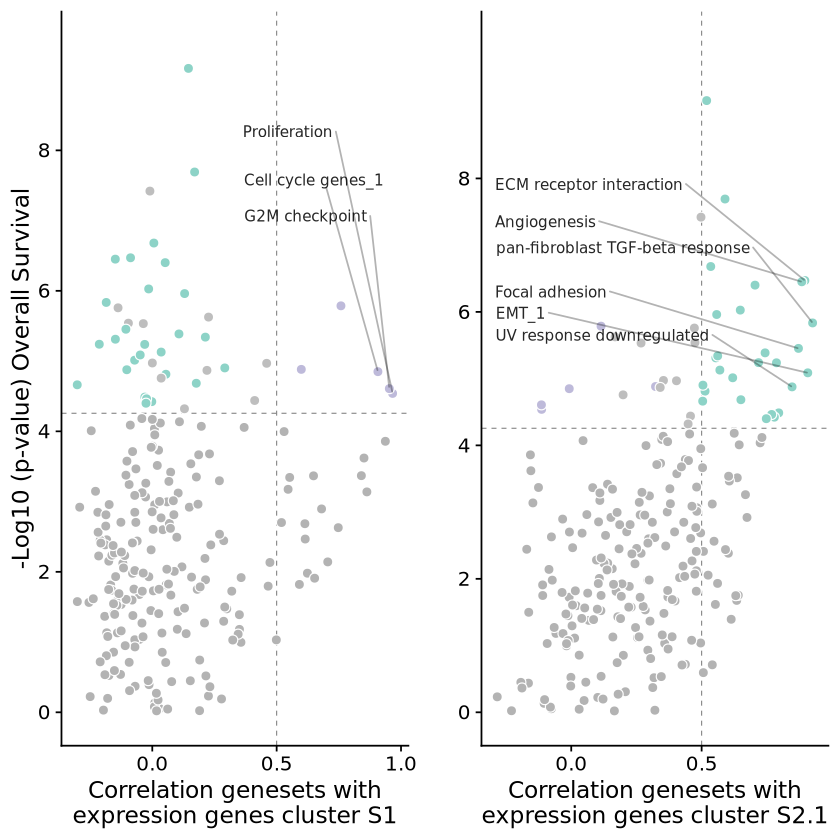

In [52]:
plot_cluster1 = input_cors2  %>% 
    ggplot(aes(x = cluster1, y = log10_p)) + 
    geom_vline(xintercept = 0.5,linetype="dashed", color = "grey50", linewidth = .3) +
    geom_hline(yintercept = threshold, linetype="dashed", color = "grey50", linewidth = .3) +
    geom_point(aes(fill = color1), size = 2.5, shape = 21, color = "white") + 
      geom_text_repel(data = labels_cl1, aes(label = label, x = cluster1, y = log10_p), max.overlaps = Inf, box.padding = 0.2, 
                    segment.alpha = 0.3,direction = "y", hjust = 0, force = 5,force_pull = 0, xlim = 0.35,
                    nudge_y = 3, min.segment.length =  0.2, alpha = 0.85, size = 3.2, show.legend = FALSE) +
    scale_fill_identity() + 
    scale_y_continuous(lim = c(0,9.5), breaks = seq(0,8,2)) + 
    cowplot::theme_cowplot() + 
    labs(x = "Correlation genesets with\nexpression genes cluster S1", y = "-Log10 (p-value) Overall Survival")

plot_cluster2 = input_cors2  %>% 
    ggplot(aes(x = cluster2, y = log10_p)) + 
    geom_vline(xintercept = 0.5,linetype="dashed", color = "grey50", linewidth = .3) +
    geom_hline(yintercept = threshold, linetype="dashed", color = "grey50", linewidth = .3) +
    geom_point(aes(fill = color2), size = 2.5, shape = 21, color = "white") + 
      geom_text_repel(data = labels_cl2, aes(label = label), max.overlaps = Inf, box.padding = 0.1, 
                      nudge_y = 1,segment.alpha = 0.3, direction = "y", hjust = 0, force = 2,force_pull = 0,
                      xlim = -0.3,
                    min.segment.length =  0.2, alpha = 0.85, size = 3.2, show.legend = FALSE) +
    scale_fill_identity() + 
    scale_y_continuous(lim = c(0,10), breaks = seq(0,8,2)) + 
    cowplot::theme_cowplot() + 
    labs(x = "Correlation genesets with\nexpression genes cluster S2.1", y = "")

total_plots = ggarrange(plot_cluster1 , plot_cluster2)
total_plots
#ggsave("1_figures/supplement/Extended_data_figure_3B.png", total_plots, width = 7, height = 4, dpi = 600)
#ggsave("1_figures/supplement/Extended_data_figure_3B.pdf", total_plots, width = 7, height = 4)

## New figure 3E

In [71]:
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))
threshold <- -log10(ingredients$by_05_fdr[1])

In [72]:
labels <- readRDS(paste0(TMP_DIR,"exhaustive-plots-labels.Rds"))

In [73]:
# filter the systemic clinical composite part from the ingredients file
ingredients = ingredients %>%
    filter(!feature %in% drop_features)  %>% 
    filter(feature != "clinical_systemic_composite" & feature != "pretreat") %>% 
    filter(!grepl("cibersort", feature)) %>% 
    mutate(big_group = case_when(big_group == "CNV" ~ "CNV/SVs",
                                 big_group =="SVs" ~ "CNV/SVs", .default = big_group))

In [74]:
labels$clean_label <- ifelse(labels$feature %in% c("isofox_gene_set_t_cell_effector"), 
                             "T-cell effector gene set", as.character(labels$clean_label))
labels$clean_label <- ifelse(labels$feature %in% c("clinical_meta_hasSystemicPreTreatment2"),
                             "Prior systemic therapy", as.character(labels$clean_label))

In [75]:
color_map$RNA = "grey" # change the RNA color to orange to make it a bit more visible. Original color: "#FC913A"
color_map$`CNV/SVs` <- "#B3DE69"
color_map$Somatic <- "#80B1D3"
color_map$CNV <- color_map$SVs <- NULL
set.seed(12345) # set seed to keep the same 'random' order
ingredients$pval_significance = ifelse(ingredients$p_val <= ingredients$by_05_fdr, "sign", "non-sign")
ingredients =  ingredients[sample(nrow(ingredients)),]

In [76]:
level = ingredients$big_group |> table() |> sort(decreasing = TRUE) |> names()
order = order(factor(ingredients$big_group, levels = level)) # make a factor for ordering the data
ingredients = ingredients[order, ]

In [77]:
# Read T-cell features
T_cell_features = data.table::fread("ref/features_Tcell.csv")[[1]] %>% as.character()

In [78]:
input_cors_tgfb = input_cors  %>% filter(grepl("TGF", cluster) & correlation > 0.5)

In [79]:
ingredients_plot = ingredients  %>% 
    mutate(big_group2 = case_when(feature %in% T_cell_features ~ "RNA: T-cell",
                                  feature %in% input_cors_tgfb$feature ~ "RNA: TGF-beta",
                                 .default = big_group))

In [80]:
tbl = ingredients_plot  %>% 
    filter(log10_p > threshold)   %>% 
    filter(group != "Gene Set")  %>% 
    filter(!grepl("somatic", feature))  %>% 
    select(feature, big_group2, log10_p, plot_est, starts_with("cor"))  %>% 
    rename("1/hazard_ratio" = "plot_est", "category" = "big_group2")  %>% 
    arrange(log10_p)
#readr::write_excel_csv(tbl, "1_figures/figure3/Figure3e.csv")

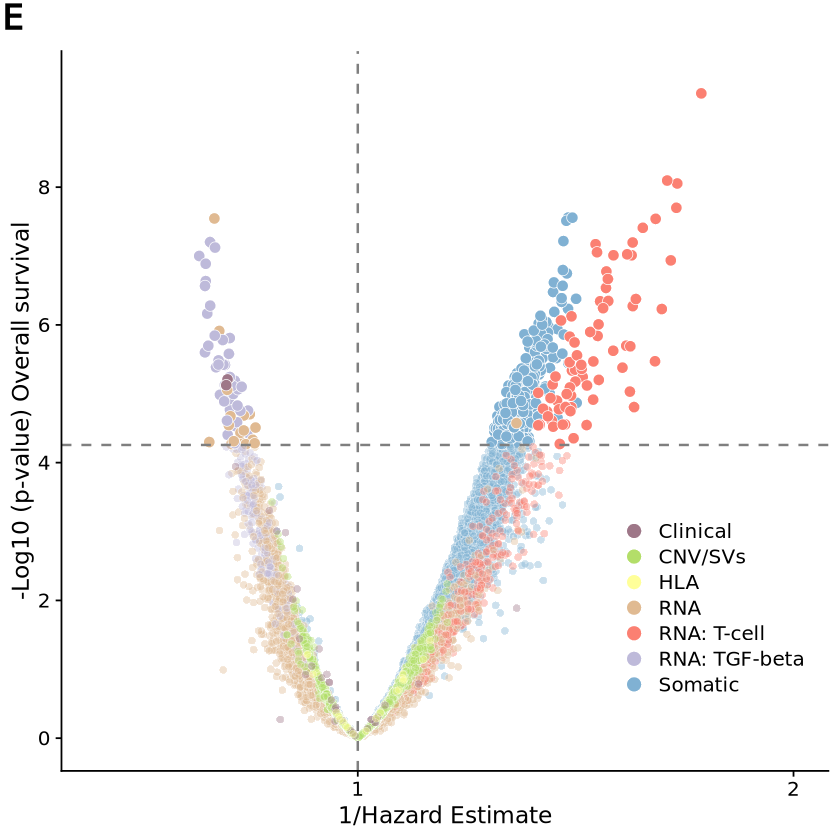

In [81]:
ingredients_plot = ingredients_plot %>%
    filter(Group != "Gene Set",
           dataset == "all",
           model == "os" ,
           covariates == "age_biopsy_purity_tissue")

fig3e = ggplot(ingredients_plot, aes(x = plot_est, y = log10_p,
                           size = log10_p > threshold, 
                           alpha = log10_p > threshold)) + 
    geom_point(aes(fill = big_group2), shape = 21, stroke = 0.3, color = "white") + 
    scale_y_continuous(breaks = c(seq(0,10,2)), limits = c(0,9.5)) + 
    scale_x_continuous(breaks = c(1, 2), limits = c(0.4,2))  +
    scale_size_manual(values = c(2, 3))  +
    scale_alpha_manual(values = c(0.4, 1)) + 
    cowplot::theme_cowplot() + 
    theme(legend.position = c(0.73, 0.25),
          legend.background = element_blank(),
          legend.box.background = element_blank()) + 
    scale_fill_manual(values = c("#9E7788", "#B3DE69","#FFFF99","#e0ba92", "#FB8072","#BEBADA","#80B1D3") ) + 
    geom_vline(xintercept = 1, linetype="dashed", color = "grey50", linewidth=0.7) + 
    geom_hline(yintercept = threshold, linetype="dashed", color = "grey50", linewidth=0.7) + 
    guides(alpha = "none", size = "none", 
           fill = guide_legend(title = "", override.aes = list(size=4)),
           color = guide_legend(title = "")) +
    labs(title = "", x = "1/Hazard Estimate", y = "-Log10 (p-value) Overall survival")    
fig3e <- annotate_figure(fig3e, fig.lab = "E", fig.lab.size = 20, fig.lab.face = "bold")
fig3e

# new figures E and F 

for E and F: Two plots where each dot is a gene RNA feature significant in survival correcte dby response
 - Y axis is log10 pvalue of survival corrected
 - X axis E is the correlation with the cluster S1 (and add dot for Proliferation potential)
 - X axis F is the correlation with cluster S2.1 (add one dot for the Pan TBRS geneset)

In [82]:
lead_sets = c("isofox_gene_set_prolif", "isofox_gene_set_Pan_TBRS")
input_cors_3EF = input_cors  %>% 
    filter(cluster != "Expression cluster S2.2")  %>% 
    filter(!grepl("gene_set", feature) | feature %in% lead_sets) %>% 
    pivot_wider(names_from = "cluster", values_from = "correlation")  %>% 
    mutate(color = case_when(`Expression cluster S1 = Proliferation potential` > 0.5 ~ "RNA: proliferation",
                             `Expression cluster S2.1 = TGF-beta fibroblasts` > 0.5 ~ "RNA: TGF-beta",
                             .default = "RNA"))

input_cors_3EF = input_cors_3EF  %>% 
    pivot_longer(names_to = "cluster", values_to = "correlation", cols = c(`Expression cluster S2.1 = TGF-beta fibroblasts`,
                   `Expression cluster S1 = Proliferation potential`))  %>% 
    mutate(size = correlation > 0.5 & log10_p > threshold) 

In [83]:
gene_list = c("CD248", "COL4A1", "COL4A2", "THY1",  # TGFB-specific features
             "ANLN", "MKI67", "TOP2A", "KIF11")
genelist = paste0("isofox_", gene_list)

label_cors_3EF = input_cors_3EF %>%  
    filter(correlation >0.5)  %>% 
    filter(feature %in% genelist)

In [84]:
label_cors_3EF = rbind(label_cors_3EF, input_cors_3EF  %>% 
                       filter(correlation > 0.7 & feature %in% lead_sets))  %>% 
    mutate(label = gsub("isofox_|gene_set_", "", feature))  %>% 
    mutate(label = case_when(label == "prolif" ~ "Proliferation\npotential", 
                             label == "Pan_TBRS" ~ "TGF-beta fibroblasts", 
                            .default = label))

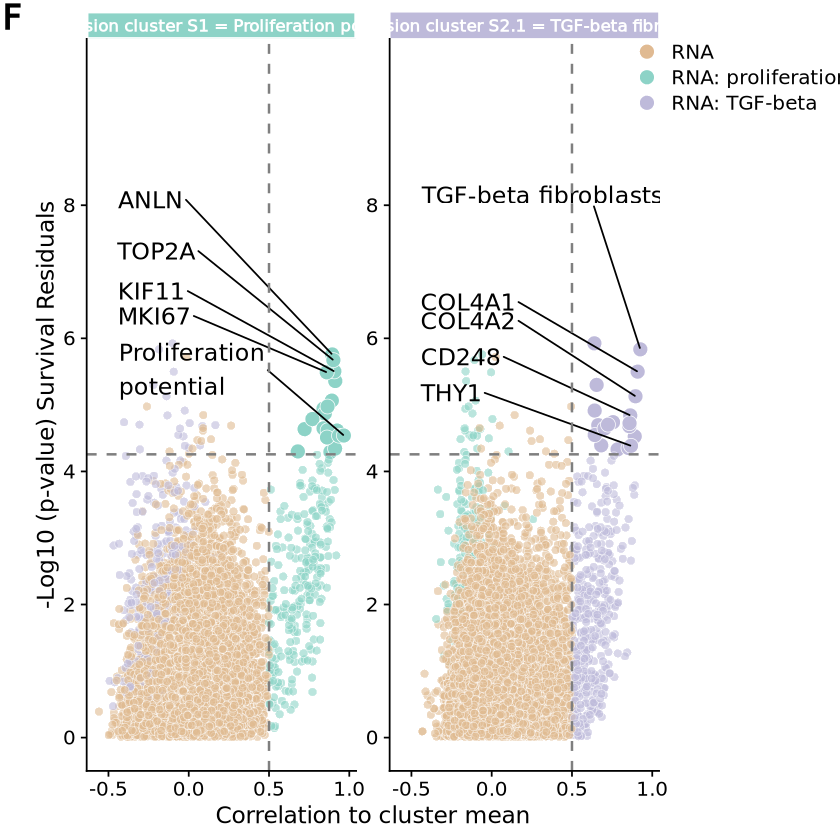

In [85]:
fig3f = ggplot(input_cors_3EF %>% drop_na() ,
               aes(x =correlation, y = log10_p)) + 
    geom_point(aes(fill = color, size = size, color = size, alpha = size), 
               shape = 21, color = "white", stroke = 0.3) + 
    facet_grid2( . ~ cluster, axes = "y",
                strip = strip_themed(background_x = elem_list_rect(fill = c("#8DD3C7","#BEBADA"), size= 1))) + 
    geom_text_repel(data = label_cors_3EF, aes(label = label), max.overlaps = Inf, box.padding = 0.4,
                   direction = "y",hjust = 0, xlim = -0.5, force = 1, size = 5, nudge_y = 1) +
    cowplot::theme_cowplot() + 
    scale_y_continuous(breaks = seq(0,8,2), lim = c(0,10)) + 
    scale_alpha_manual(values = c(0.6, 1)) +
    scale_size_manual(values = c(2.2,4)) +
    scale_color_manual(values = c("black", "black", "white")) + 
    scale_fill_manual(values = c("#e0ba92", "#8DD3C7", "#BEBADA")) + # orginal colors: "#B3DE69",  "#FC913A"
    geom_vline(xintercept = 0.5, linetype="dashed", color = "grey50", linewidth = .7) +
    geom_hline(yintercept = threshold, linetype="dashed", color = "grey50", linewidth = .7) +
    guides(alpha = "none", color = "none", size = "none", # remove the 'pval size'
           fill = guide_legend(title = NULL, override.aes = list(size = 4))) +
    theme(strip.background = element_rect(color = "white"), legend.justification = "top",
          legend.box.spacing = margin(-15),
          legend.background = element_blank(),
          legend.box.background = element_blank(),
          strip.text = element_text(color = "white", face = "bold", size = 10)) +
    xlab("Correlation to cluster mean") + ylab("\n-Log10 (p-value) Survival Residuals")

fig3f = annotate_figure(fig3f, fig.lab = "F", fig.lab.size = 20, fig.lab.face = "bold")
fig3f

### Supplementary figure: Correlation of cluster 3 genes with cluster 2 (TGF-beta)

In [86]:
cl2.2_cors_to_meancl2.1 = input_cors  %>%
    filter(feature %in% names(cluster2.2), cluster == "Expression cluster S2.2")  %>%
    mutate("cluster origin" = "cluster S2.2")

cl2.1_cors_to_meancl2.2 = input_cors  %>%
    filter(feature %in% names(cluster2.1),   
           cluster == "Expression cluster S2.1 = TGF-beta fibroblasts")  %>%
    mutate("cluster origin" = "cluster S2.1")

cors_cl2.1_2.2 = rbind(cl2.2_cors_to_meancl2.1, cl2.1_cors_to_meancl2.2)

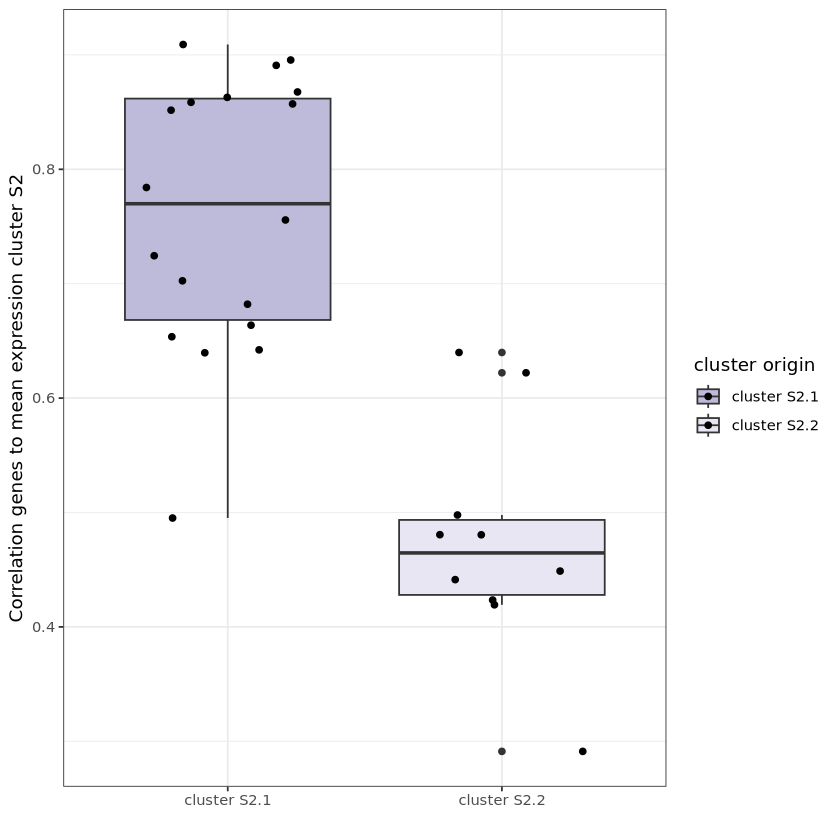

In [87]:
cor_to_cl2 = ggplot(cors_cl2.1_2.2, aes(x = `cluster origin`, y = correlation, fill = `cluster origin`)) +
    geom_boxplot(outlier.shape = NULL) +
    geom_jitter(width = 0.3) + 
    theme_bw() + 
    scale_fill_manual(values = c("#BEBADA", "#e8e6f2")) + 
    xlab("") + ylab("Correlation genes to mean expression cluster S2")
cor_to_cl2
#ggsave("1_figures/figure3/Supplementary_figureX.pdf", cor_to_cl2, width = 4.5, height = 4.5)
#ggsave("1_figures/figure3/Supplementary_figureX.png", cor_to_cl2, width = 4.5, height = 4.5)

### Figure 3I

Plot to determine the absence of any other clear features after removing all the significant samples

### Combining and saving plots

In [88]:
# rsvg_svg("/workspace/users/arosendahl/immune_biomarkers/ref/latent_factor_5_full.svg", "/workspace/users/arosendahl/immune_biomarkers/ref/latent_factor_5_cairo.svg")

# SVGlogo <- readPicture("/workspace/users/arosendahl/immune_biomarkers/ref/latent_factor_5_cairo.svg")
# svg_pic = pictureGrob(SVGlogo, ext="gridSVG", delayContent=FALSE)
# svg_pic = annotate_figure(svg_pic, fig.lab = "G", fig.lab.size = 20, fig.lab.face = "bold") +
#     theme(plot.margin=margin(0,0,10,0, unit = "mm"))

In [91]:
pl = list(fig3a, fig3b, fig3c, fig3d, fig3e, fig3f)
pl = lapply(pl, "+", theme(plot.margin=margin(5,5,5,5, unit = "mm")))
pl[[1]] = pl[[1]] + theme(plot.margin=margin(5,7,7,2, unit = "mm"))
pl[[3]] = pl[[3]] + theme(plot.margin=margin(5,2,20,2, unit = "mm"))
pl[[4]] = pl[[4]] + theme(plot.margin=margin(5,2,20,2, unit = "mm"))
pl[[5]] = pl[[5]] + theme(plot.margin=margin(5,5,20,2, unit = "mm"))
pl[[6]] = pl[[6]] + theme(plot.margin=margin(5,5,20,2, unit = "mm"))

top = cowplot::plot_grid(pl[[1]], pl[[2]], ncol = 2)
middle = cowplot::plot_grid(pl[[3]], pl[[4]],pl[[5]], ncol = 3, rel_widths = c(1,1,1.35))
bottom = cowplot::plot_grid(pl[[6]], NULL, ncol = 2, rel_widths = c(1,0.5)) 
fig = arrangeGrob(top, middle, bottom, nrow = 3)  

ggsave("../../final_figures/figure3.png", fig, width = 16, height = 18, dpi = 1300)
ggsave("../../final_figures/figure3.pdf", fig, width = 16, height = 18, dpi = 1300)

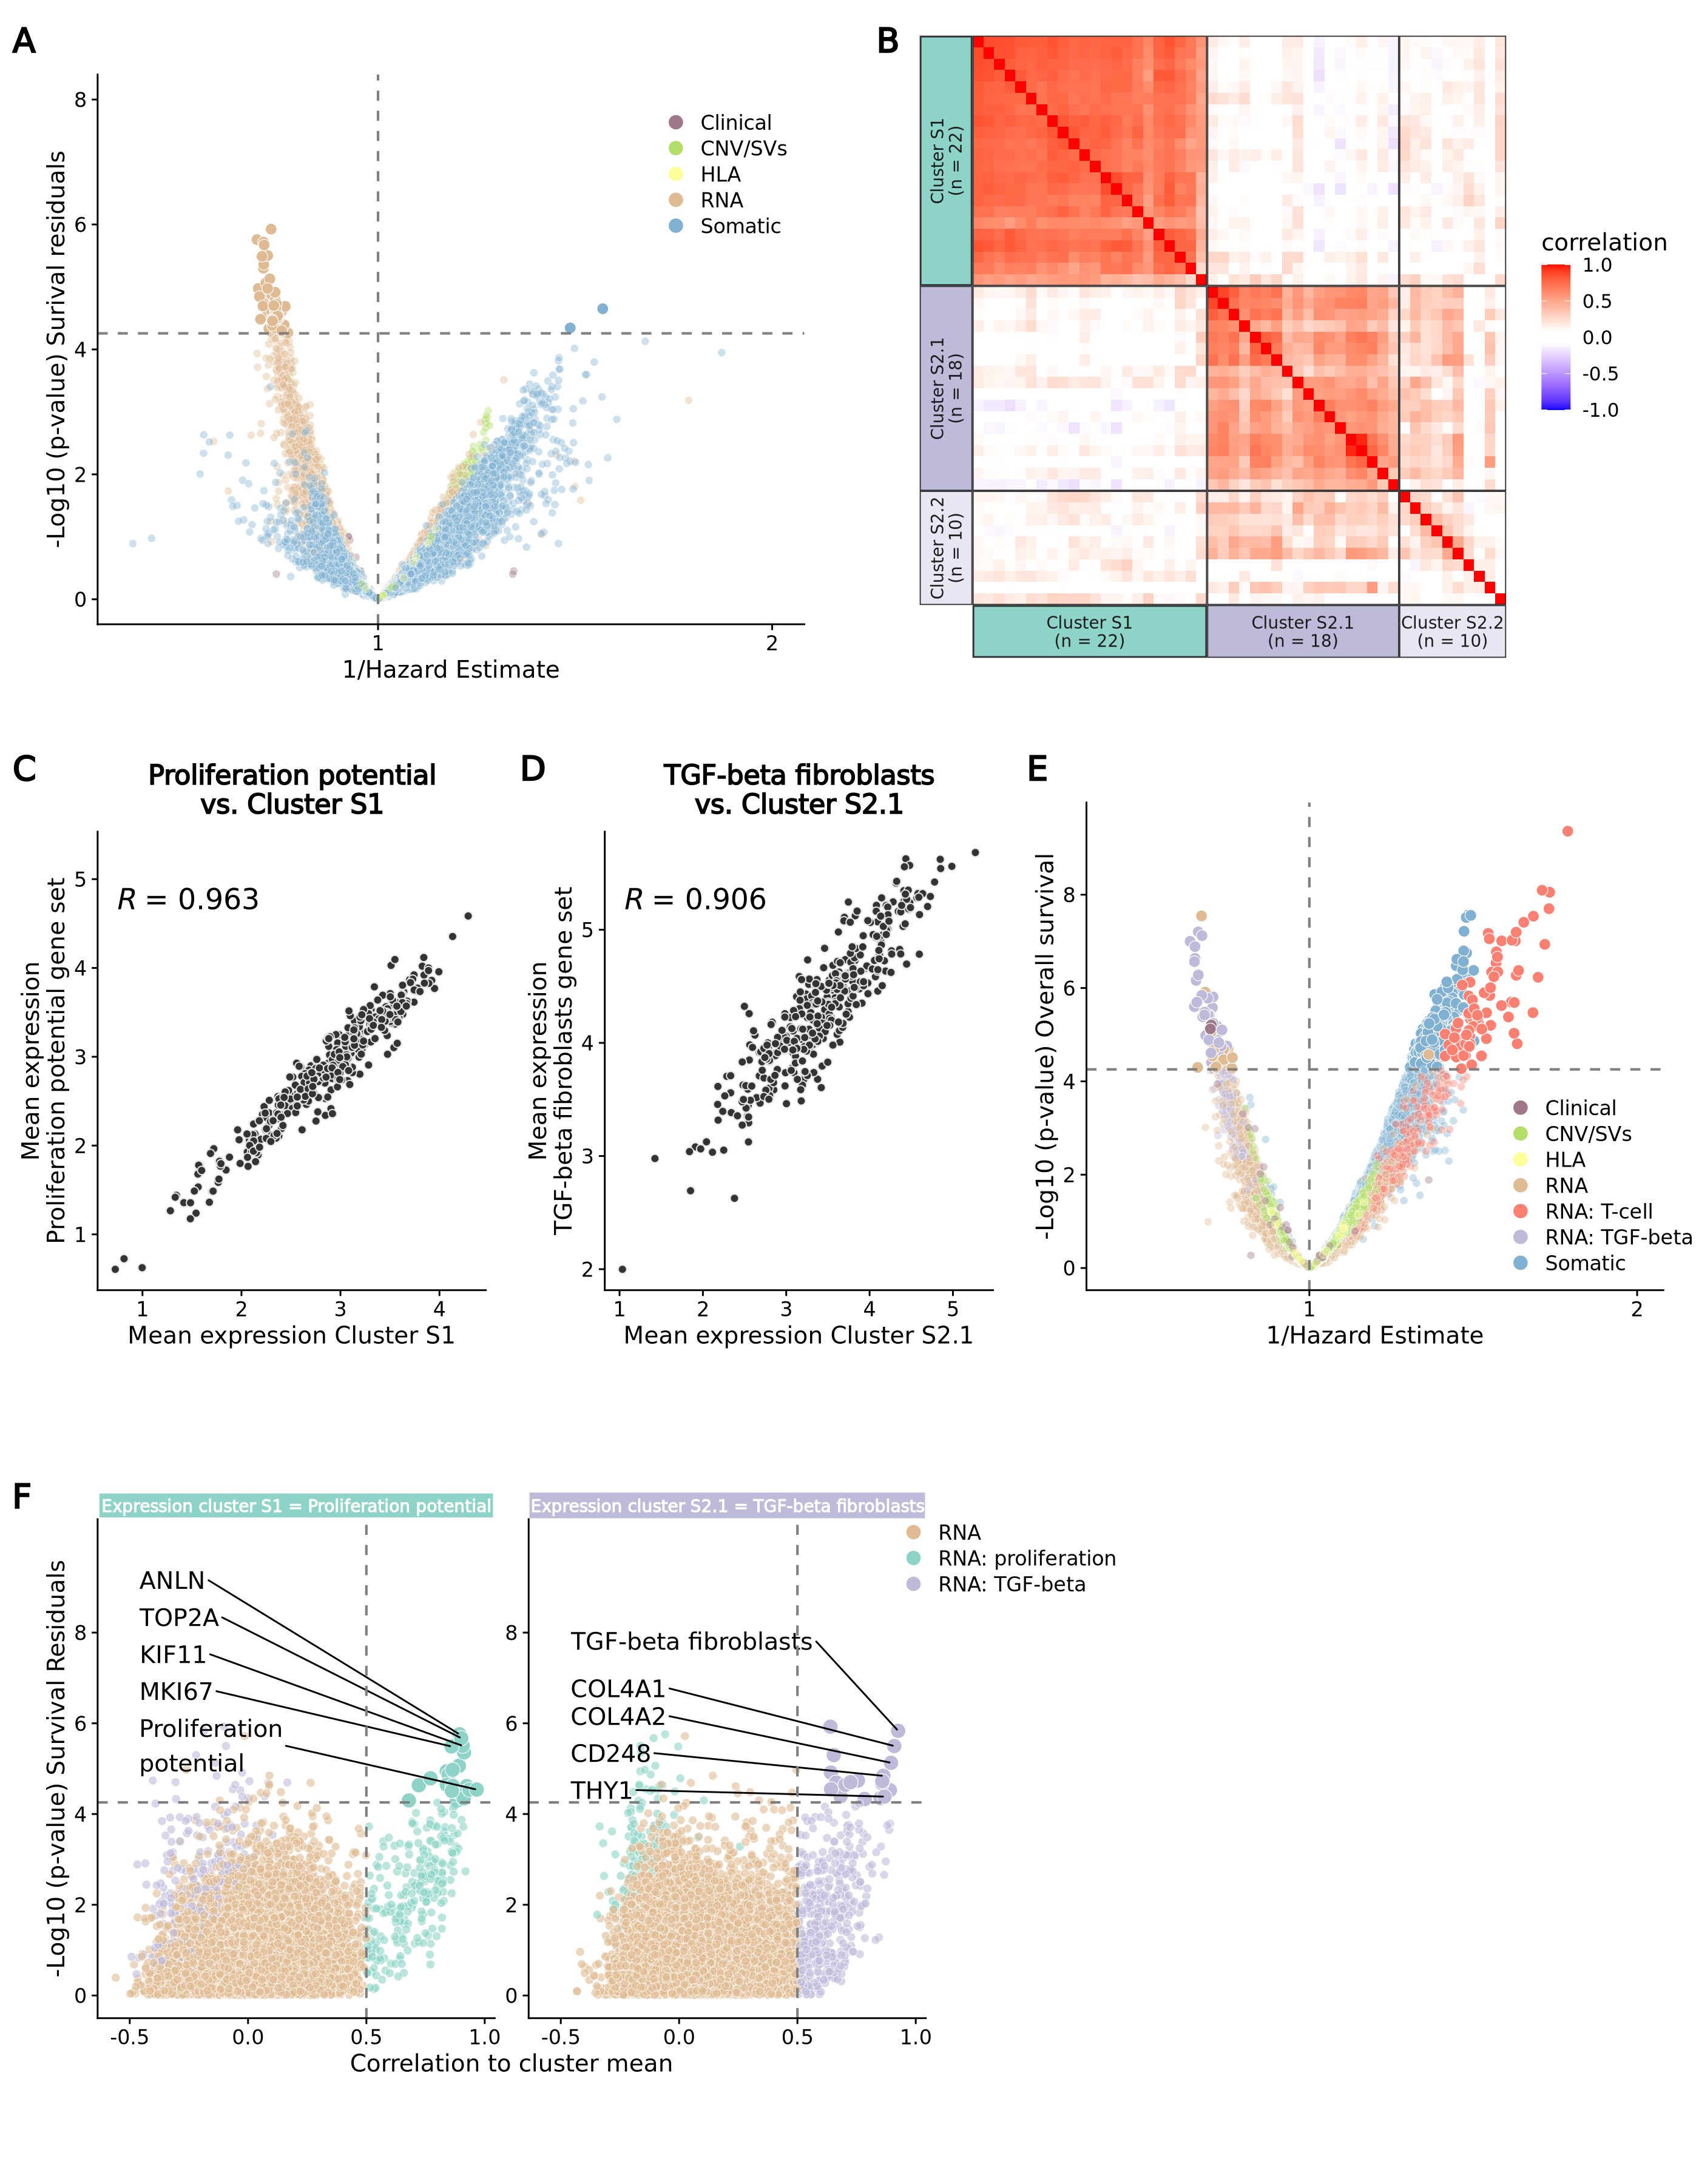

In [92]:
options(repr.plot.width = 14, repr.plot.height = 18, repr.plot.res = 200)
grid::grid.draw(fig)